In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from UNet import UNet
from MRIDataset import MRIDataset
from DiceLoss import DiceLoss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = MRIDataset()
train_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True
)

val_dataset = MRIDataset(train=False)
val_loader = DataLoader(
    val_dataset,
    batch_size = 8,
    shuffle = False
)

net = UNet(in_channels=3, out_channels=1, depth=4)
net.to(device)

criterion = DiceLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30,], gamma=0.1)

n_epochs = 150

In [3]:
train_losses = []
val_losses = []

best_loss = 1
ebar = tqdm(total=n_epochs, desc=f"Loss: 0 [0]", leave=False)
for epoch in range(n_epochs):
    net.train()

    train_loss = 0
    ibar = tqdm(total=len(train_loader), desc="Loss: 0", leave=False)
    for x, y_true in train_loader:
        x, y_true = x.to(device), y_true.to(device)

        optimizer.zero_grad()

        y_pred = net(x)
        loss = criterion(y_pred, y_true)

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        ibar.set_description(f"Trainining loss: {loss.item():.03f}")
        ibar.update(1)
    ibar.close()
    
    scheduler.step()
    
    net.eval()
    val_loss = 0
    ibar = tqdm(total=len(val_loader), desc="Loss: 0", leave=False)
    with torch.no_grad():
        for x, y_true in val_loader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y_true)
            val_loss += loss.item()
            ibar.set_description(f"Validation loss: {loss.item():.03f}")
            ibar.update(1)
        ibar.close()
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    ebar.set_description(f"Loss: {train_loss:.03f} [{val_loss:.03f}]")
    ebar.update(1)
    
    if (val_loss <= best_loss):
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss
            }, 
            'unet.pt'
        )

ebar.close()

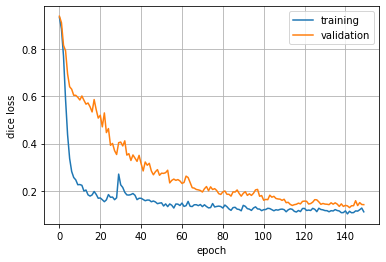

In [4]:
plt.plot(np.mean(np.array(train_losses).reshape(n_epochs, -1), axis=1), label='training')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('dice loss')
plt.legend()
plt.grid()
plt.show()

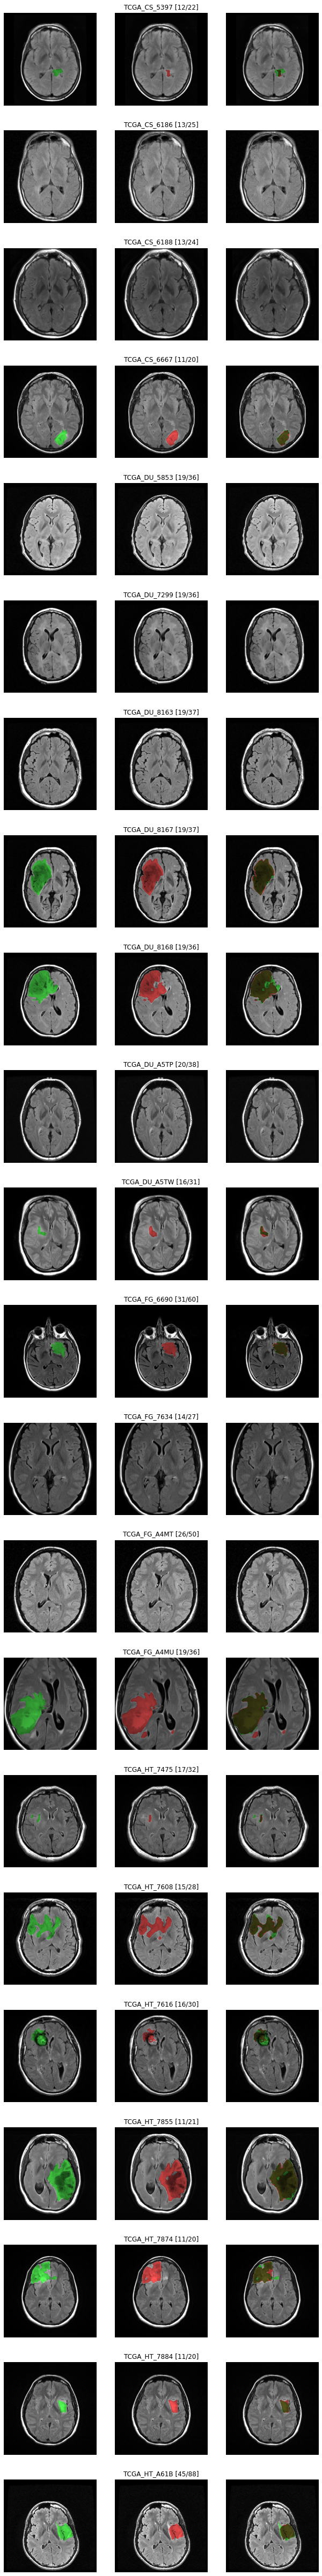

In [5]:
ckpt = torch.load('unet.pt')
net.load_state_dict(ckpt['state_dict'])
net.eval()

patients, counts = np.unique(val_dataset.dataset.patients, return_counts=True)
_, ax = plt.subplots(len(patients), 3, figsize=(3*3.5, len(patients)*4))

for i in range(len(patients)):
    idx = np.sum(counts[:i]) + counts[i]//2
    with torch.no_grad():
        x, y_true = val_dataset[idx]
        x, y_true = x.to(device), y_true.to(device)
        x = x[np.newaxis, ...]
        y_pred = net(x)
    y_pred = y_pred.cpu().numpy().squeeze()
    y_pred = (y_pred > 0.5)
    y_true = y_true.cpu().numpy().squeeze()
    x = x[:, 1].cpu().numpy().squeeze()
    
    img = np.moveaxis(np.array([x, x, x]), 0, 2)
    slice = val_dataset.dataset.slices[idx]
    
    img_true = img.copy()
    img_true[..., 0][y_true == 1] /= 3
    img_true[..., 2][y_true == 1] /= 3
    ax[i][0].imshow(img_true)
    ax[i][0].axis('off')
    
    img_pred = img.copy()
    img_pred[..., 1][y_pred] /= 3
    img_pred[..., 2][y_pred] /= 3
    ax[i][1].imshow(img_pred)
    ax[i][1].set_title(f"{patients[i]} [{slice}/{counts[i]}]", pad=8)
    ax[i][1].axis('off')
    
    img[..., 0][y_true == 1] /= 3
    img[..., 2][y_true == 1] /= 3
    img[..., 1][y_pred] /= 3
    img[..., 2][y_pred] /= 3
    ax[i][2].imshow(img)
    ax[i][2].axis('off')

plt.show()

In [6]:
best_loss

0.12898290659251965